## Load and preprocess data
Load the processed dataset, separate into features/target, split into train/test using ZIPs, and scale the features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("final_processed_dataset.csv")
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")

# Separate rows with and without target
df_model = df[df["YoY_target"].notna()].copy()
future_df = df[df["YoY_target"].isna()].copy()

# Separate features and target
y = df_model["YoY_target"]
X = df_model.drop(columns=["YoY_target"])

# Drop NA rows
X = X.dropna()
y = y.loc[X.index]

# Train/test split based on ZIP
unique_zips = X["ZIP"].unique()
train_zips, test_zips = train_test_split(unique_zips, test_size=0.2, random_state=42)

train_mask = X["ZIP"].isin(train_zips)
X_train_raw = X[train_mask].copy()
X_test_raw = X[~train_mask].copy()
X_train = X_train_raw.drop(columns=["ZIP"])
X_test = X_test_raw.drop(columns=["ZIP"])

y_train = y[train_mask]
y_test = y[~train_mask]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Loaded dataset with 5343 rows and 139 columns.


## Top 20 features by method
Rank features using F-regression and mutual information, and visualize top 20 from each method.

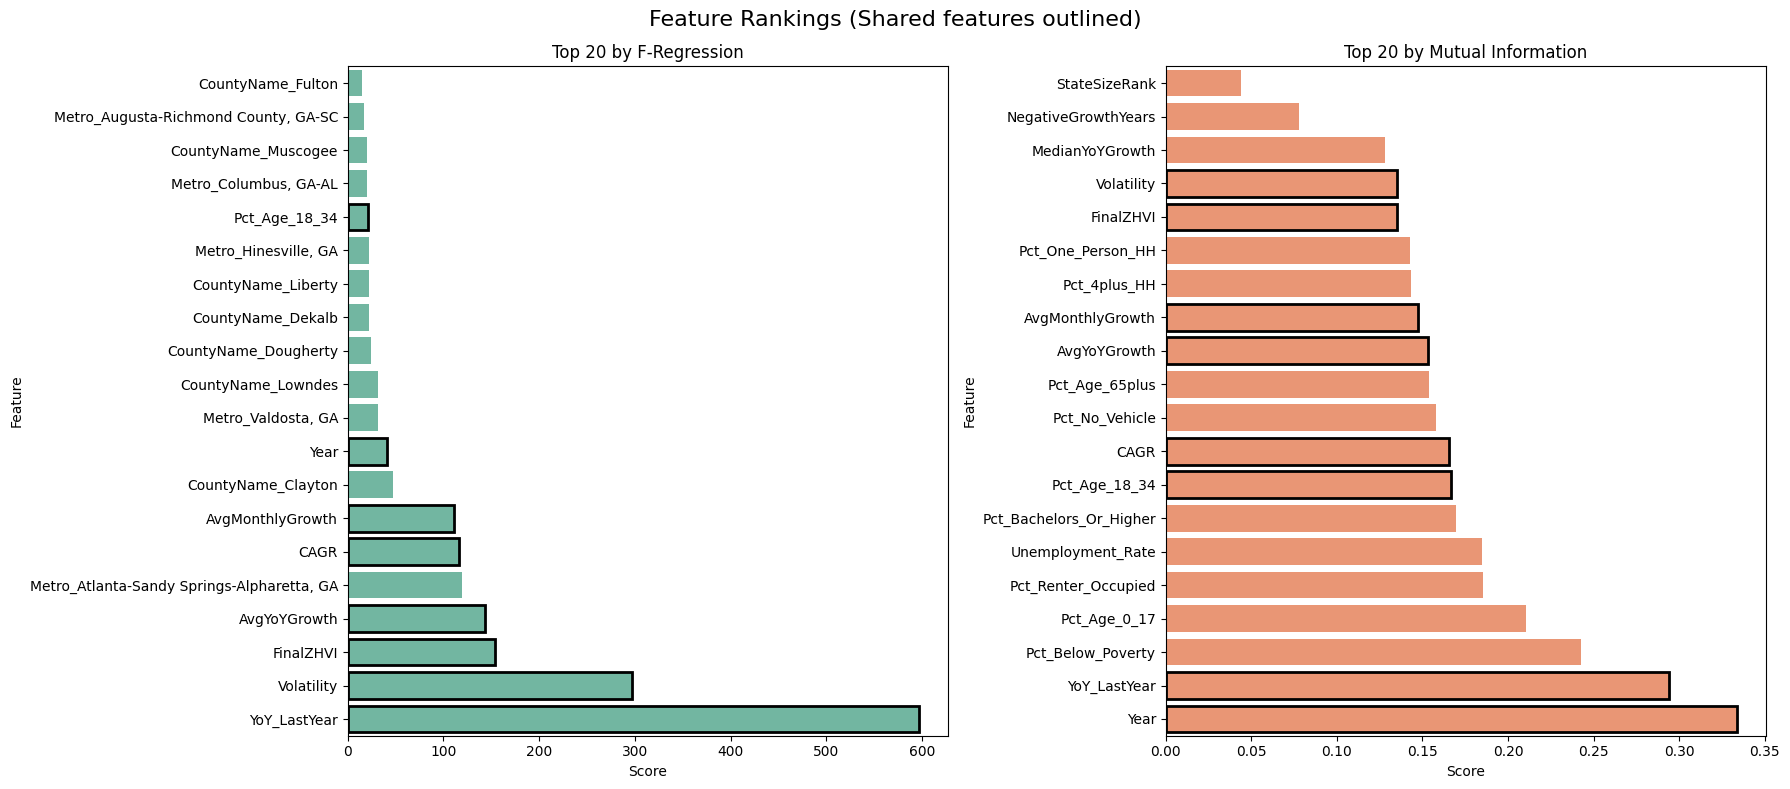

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

# F-regression
selector_f = SelectKBest(score_func=f_regression, k=20)
selector_f.fit(X_train_scaled, y_train)
top_f = pd.DataFrame({
    "Feature": X_train.columns,
    "Score": selector_f.scores_
}).sort_values(by="Score", ascending=False).head(20)

# Mutual Info
selector_mi = SelectKBest(score_func=mutual_info_regression, k=20)
selector_mi.fit(X_train_scaled, y_train)
top_mi = pd.DataFrame({
    "Feature": X_train.columns,
    "Score": selector_mi.scores_
}).sort_values(by="Score", ascending=False).head(20)

# Shared features
shared = set(top_f["Feature"]) & set(top_mi["Feature"])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
set2 = sns.color_palette("Set2")

sns.barplot(x="Score", y="Feature", data=top_f.sort_values(by="Score"), ax=axs[0], color=set2[0])
axs[0].set_title("Top 20 by F-Regression")
for bar, label in zip(axs[0].containers[0], top_f.sort_values(by="Score")["Feature"]):
    if label in shared:
        bar.set_edgecolor("black")
        bar.set_linewidth(2)

sns.barplot(x="Score", y="Feature", data=top_mi.sort_values(by="Score"), ax=axs[1], color=set2[1])
axs[1].set_title("Top 20 by Mutual Information")
for bar, label in zip(axs[1].containers[0], top_mi.sort_values(by="Score")["Feature"]):
    if label in shared:
        bar.set_edgecolor("black")
        bar.set_linewidth(2)

plt.suptitle("Feature Rankings (Shared features outlined)", fontsize=16)
plt.tight_layout()
plt.show()


## Benchmark feature selection
Benchmark R² scores across 1 to 50 features for each model and selection method (slow to run beware).

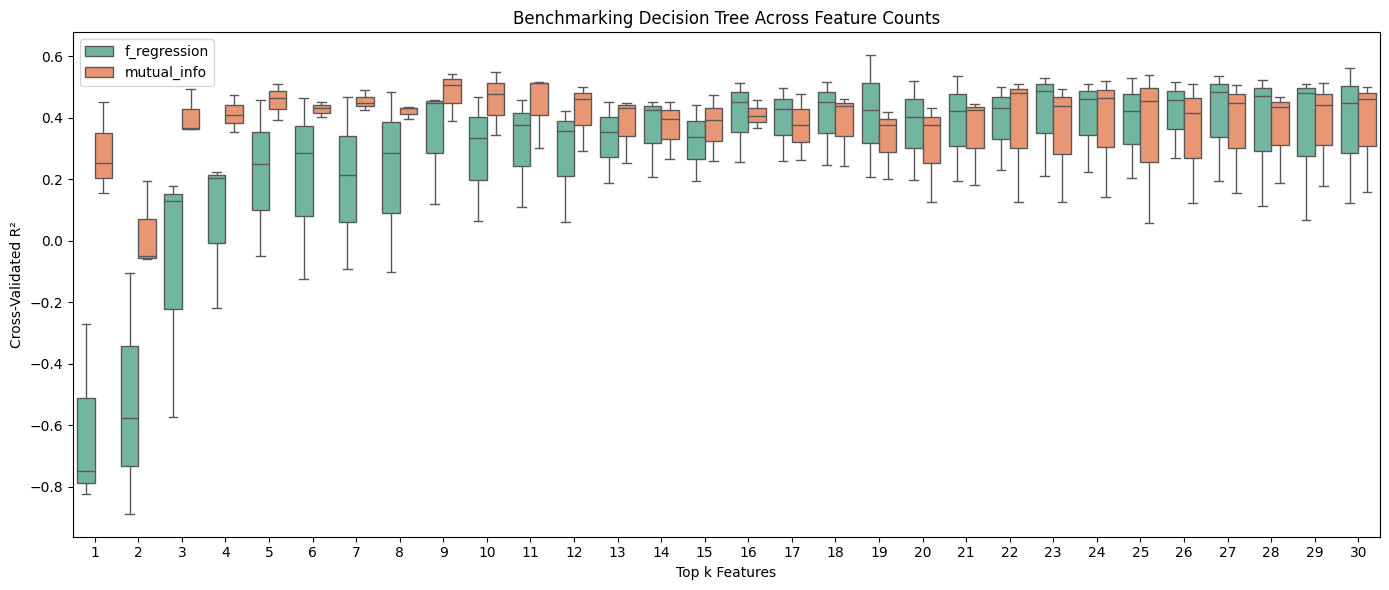

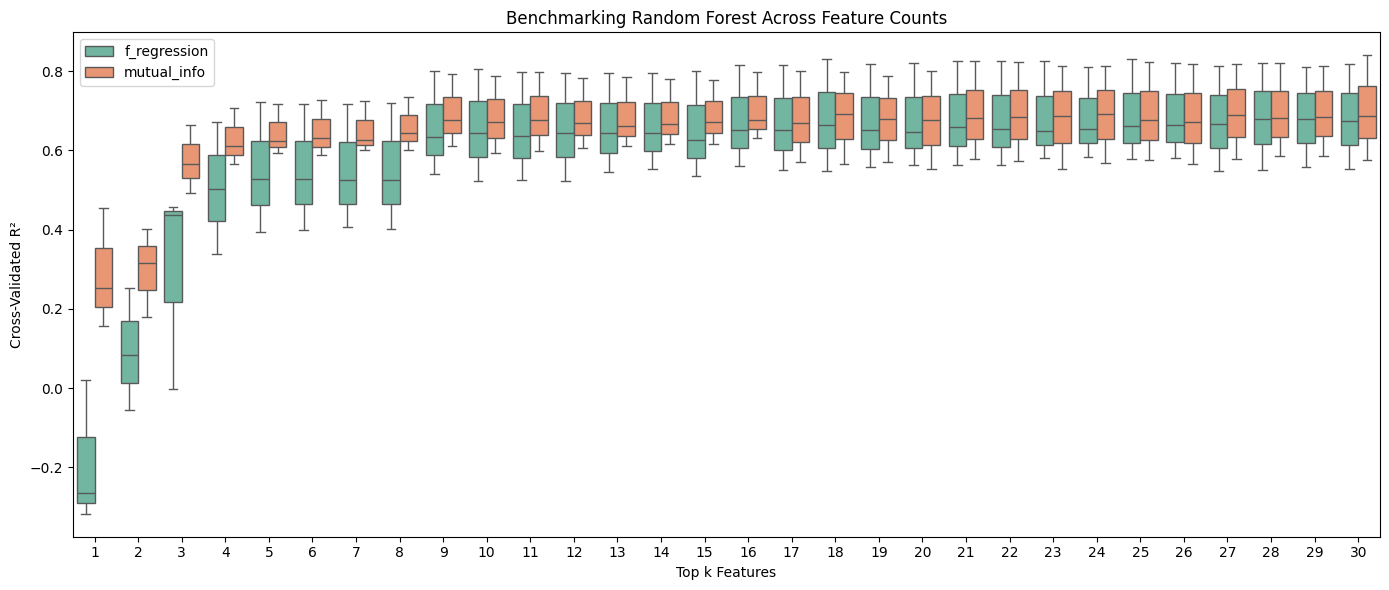

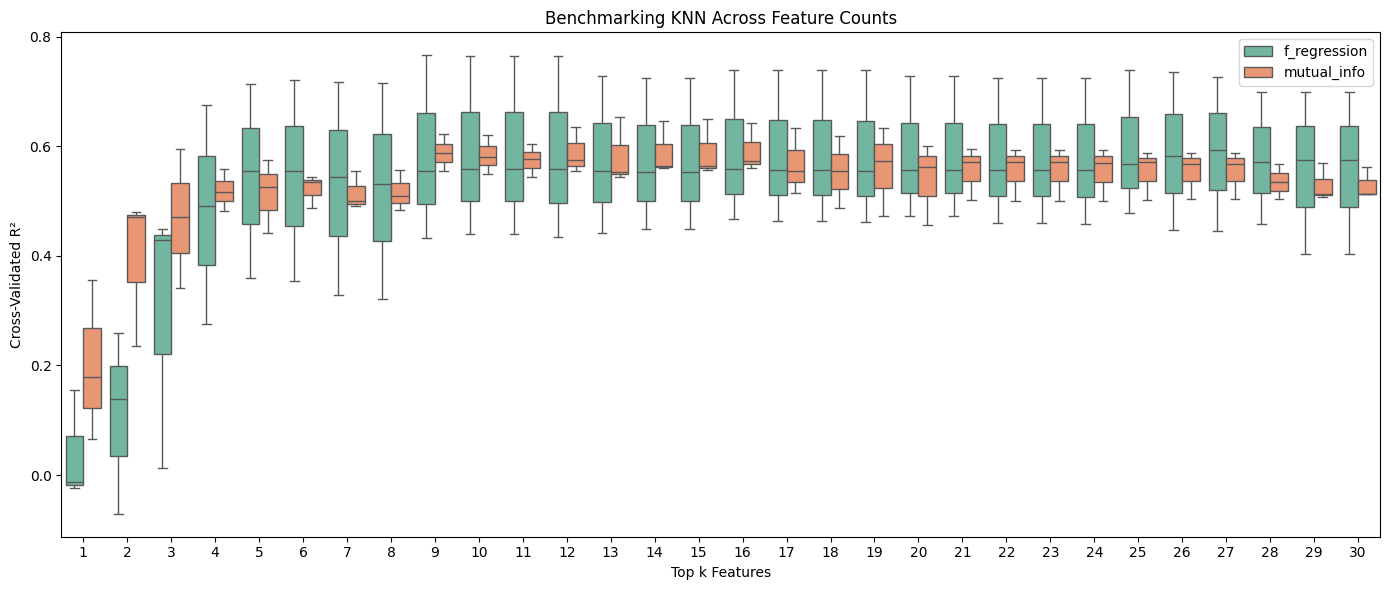

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

max_k = 30
models = {
    "Decision Tree": DecisionTreeRegressor,
    "Random Forest": RandomForestRegressor,
    "KNN": KNeighborsRegressor
}

for model_name, model_cls in models.items():
    results = []
    for k in range(1, max_k + 1):
        sel_f = SelectKBest(f_regression, k=k)
        X_k_f = sel_f.fit_transform(X_train_scaled, y_train)
        for r2 in cross_val_score(model_cls(), X_k_f, y_train, cv=3, scoring="r2"):
            results.append({"R²": r2, "k": k, "Method": "f_regression"})

        sel_mi = SelectKBest(mutual_info_regression, k=k)
        X_k_mi = sel_mi.fit_transform(X_train_scaled, y_train)
        for r2 in cross_val_score(model_cls(), X_k_mi, y_train, cv=3, scoring="r2"):
            results.append({"R²": r2, "k": k, "Method": "mutual_info"})

    df_plot = pd.DataFrame(results)
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_plot, x="k", y="R²", hue="Method", palette="Set2")
    plt.title(f"Benchmarking {model_name} Across Feature Counts")
    plt.xlabel("Top k Features")
    plt.ylabel("Cross-Validated R²")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Train and evaluate tuned models
Train Decision Tree, KNN, and Random Forest with tuned hyperparameters using **mutual information** features.

best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


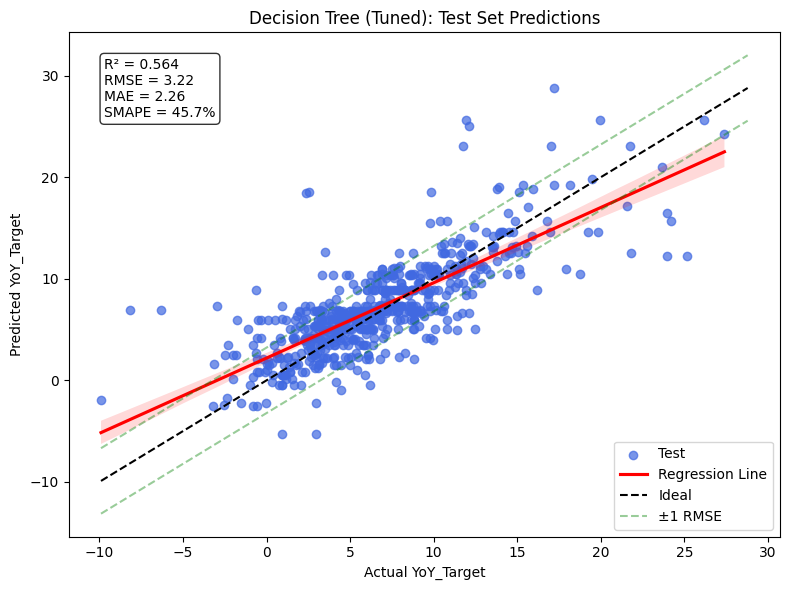

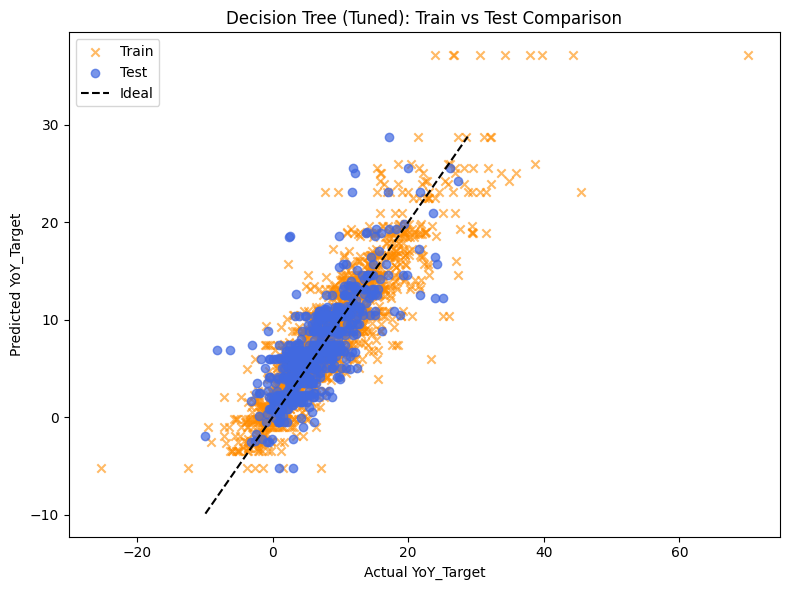

best parameters for KNN: {'n_neighbors': 5, 'weights': 'uniform'}


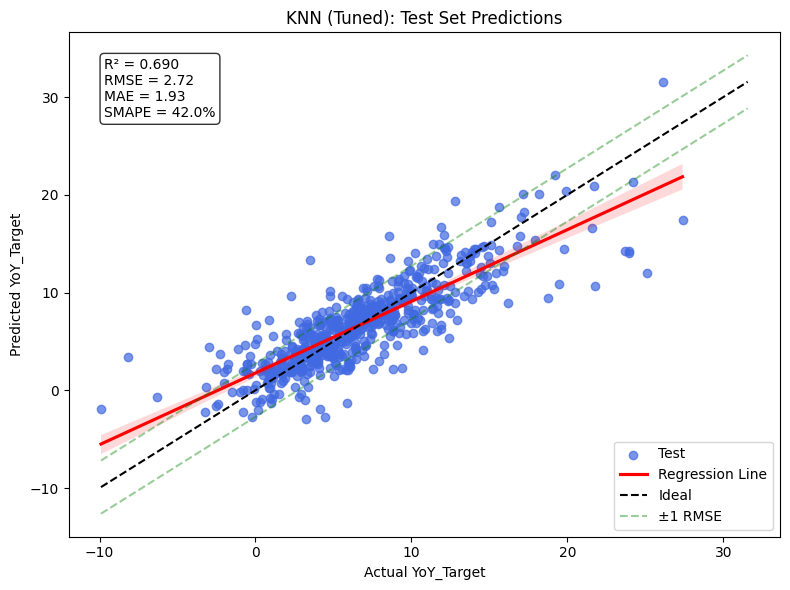

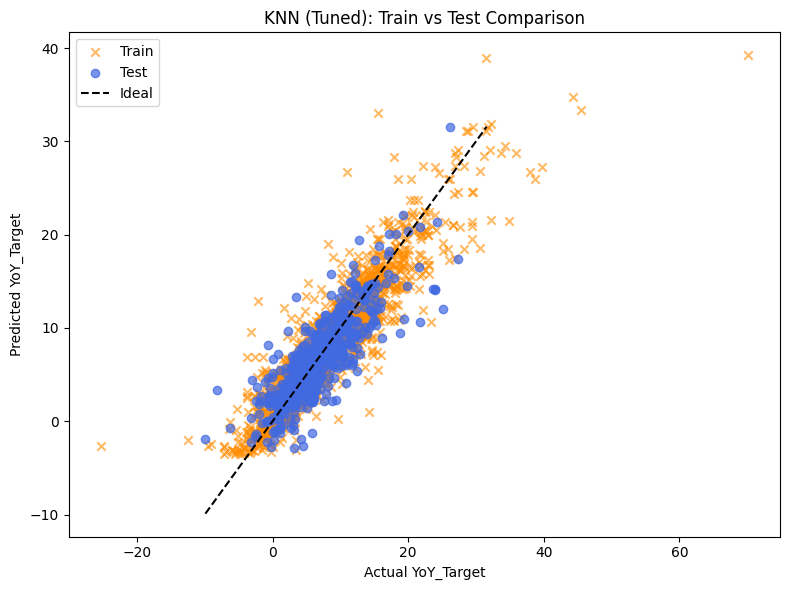

best parameters for RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


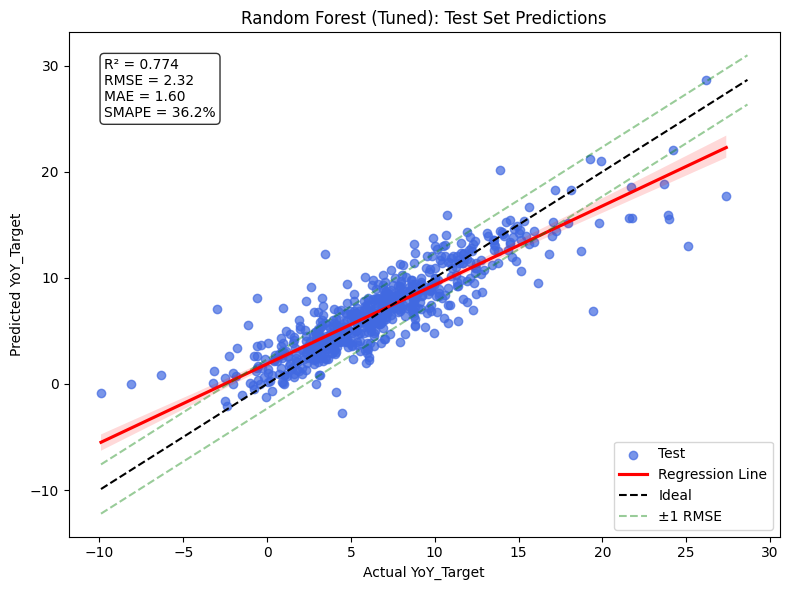

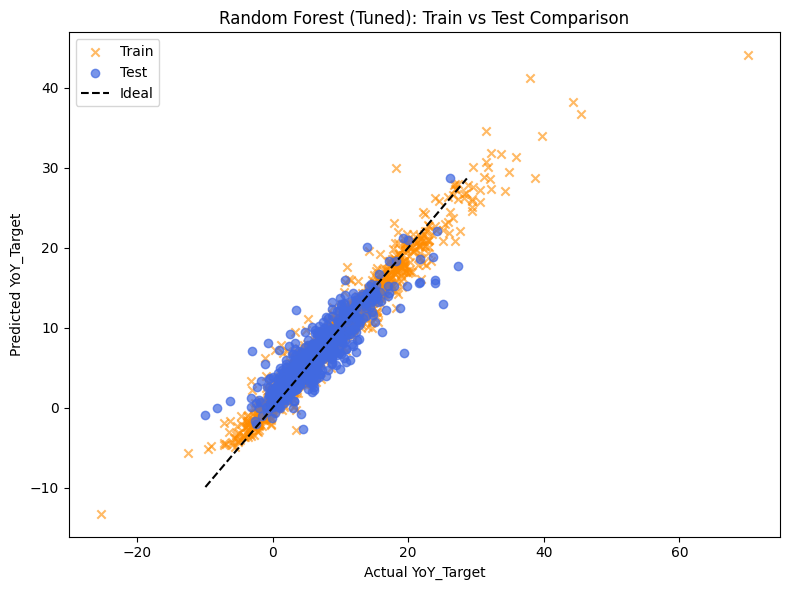

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# helper
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_vals = np.abs(y_true - y_pred) / np.where(denominator == 0, 1, denominator)
    smape = 100 * np.mean(smape_vals)
    return r2, rmse, mae, smape

model_configs = {
    "Decision Tree (Tuned)": ("gridsearch_dt", 8),
    "KNN (Tuned)": ("gridsearch_knn", 9),
    "Random Forest (Tuned)": ("gridsearch_rf", 16)
}

results = []
trained_models = {}

for name, (model, k_features) in model_configs.items():
    selector = SelectKBest(score_func=mutual_info_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train)
    X_test_sel = selector.transform(X_test_scaled)

    if model == "gridsearch_rf":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        base = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(base, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"best parameters for RF: {grid_search.best_params_}")

    elif model == "gridsearch_knn":
        param_grid = {
            'n_neighbors': [5, 6, 7, 10, 15],
            'weights': ['uniform'], # 'distance' is not used in this case because it overfits 
        }
        base = KNeighborsRegressor()
        grid_search = GridSearchCV(base, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"best parameters for KNN: {grid_search.best_params_}")

    elif model == "gridsearch_dt":
        param_grid = {
            'max_depth': [3, 5, 10],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 5]
        }
        base = DecisionTreeRegressor(random_state=42)
        grid_search = GridSearchCV(base, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"best parameters for Decision Tree: {grid_search.best_params_}")

    # fit and predict
    model.fit(X_train_sel, y_train)
    y_test_pred = model.predict(X_test_sel)
    y_train_pred = model.predict(X_train_sel)
    r2, rmse, mae, smape = evaluate(y_test.values, y_test_pred)
    results.append((name, r2, rmse, mae, smape))

    # store for reuse
    trained_models[name] = {
        "model": model,
        "selector": selector
    }

    # Plot 1 — Test Set Predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, color='royalblue', label="Test", alpha=0.7)
    sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='red', label="Regression Line")

    lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
    plt.plot(lims, lims, 'k--', label='Ideal')
    plt.plot(lims, [l + rmse for l in lims], 'g--', alpha=0.4, label='±1 RMSE')
    plt.plot(lims, [l - rmse for l in lims], 'g--', alpha=0.4)

    plt.title(f"{name}: Test Set Predictions")
    plt.xlabel("Actual YoY_Target")
    plt.ylabel("Predicted YoY_Target")
    plt.legend()

    metrics_text = f"R² = {r2:.3f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}\nSMAPE = {smape:.1f}%"
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Plot 2 — Train vs Test Scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.6, marker='x', color='darkorange', label='Train')
    plt.scatter(y_test, y_test_pred, alpha=0.7, marker='o', color='royalblue', label='Test')
    plt.plot(lims, lims, 'k--', label='Ideal')

    plt.title(f"{name}: Train vs Test Comparison")
    plt.xlabel("Actual YoY_Target")
    plt.ylabel("Predicted YoY_Target")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Predict ZIP timeline
Use trained models to predict YoY growth for all available years for 3 representative ZIPs and visualize the timeline.

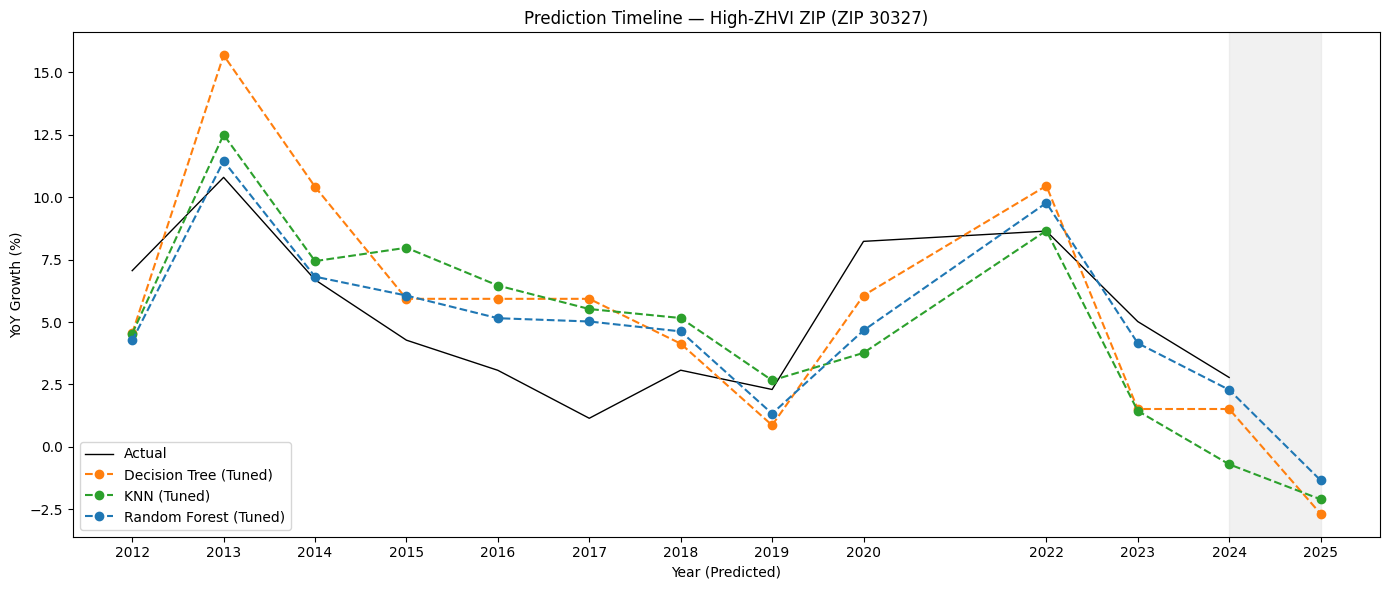

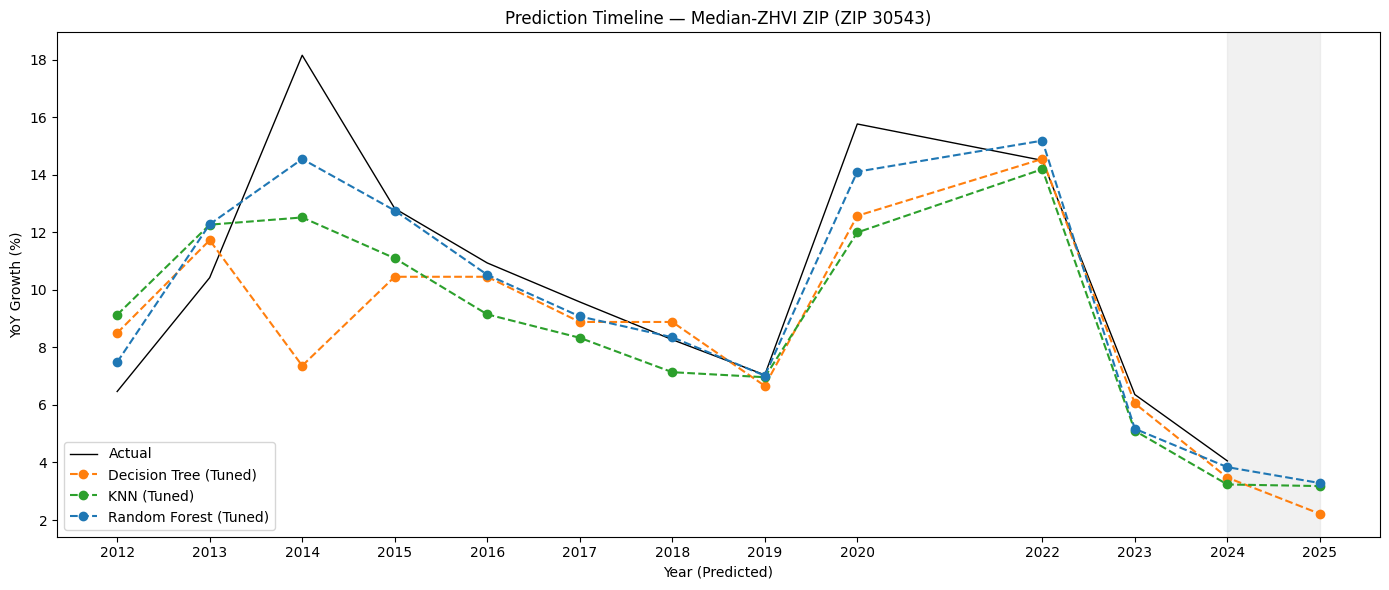

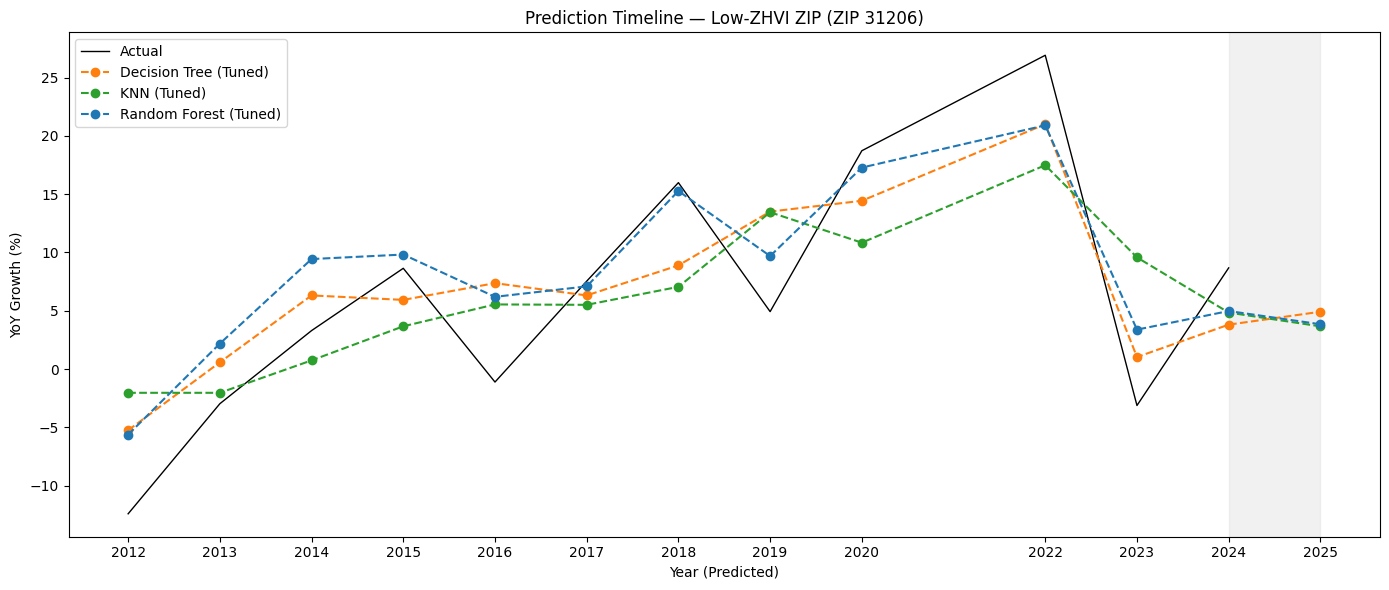

In [ ]:
import matplotlib.pyplot as plt

# use 2024 ZHVI values to select ZIPs
zhvi_2024 = df[df["Year"] == 2024][["ZIP", "FinalZHVI"]].dropna()
zhvi_2024 = zhvi_2024.groupby("ZIP").mean(numeric_only=True).reset_index()

high_zip = zhvi_2024.sort_values("FinalZHVI", ascending=False).iloc[0]["ZIP"]
low_zip = zhvi_2024.sort_values("FinalZHVI", ascending=True).iloc[0]["ZIP"]
median_zip = zhvi_2024.iloc[len(zhvi_2024) // 2]["ZIP"]

selected_zips = [high_zip, median_zip, low_zip]
zip_labels = ["High-ZHVI ZIP", "Median-ZHVI ZIP", "Low-ZHVI ZIP"]
color_map = {
    "Decision Tree (Tuned)": "tab:orange",
    "KNN (Tuned)": "tab:green",
    "Random Forest (Tuned)": "tab:blue"
}

for zip_code, label in zip(selected_zips, zip_labels):
    zip_all = pd.concat([
        df_model[df_model["ZIP"] == zip_code],
        future_df[future_df["ZIP"] == zip_code]
    ]).sort_values("Year")

    actual_rows = df_model[df_model["ZIP"] == zip_code].sort_values("Year")
    actual_years = actual_rows["Year"].values + 1
    actual_y = actual_rows["YoY_target"].values

    zip_all = zip_all.fillna(0)
    for col in X_train.columns:
        if col not in zip_all.columns:
            zip_all[col] = 0
    zip_all = zip_all[X_train.columns]
    X_zip_scaled = scaler.transform(zip_all)

    predictions = {"Actual": actual_y}
    for name, bundle in trained_models.items():
        model = bundle["model"]
        selector = bundle["selector"]
        X_selected = selector.transform(X_zip_scaled)
        predictions[name] = model.predict(X_selected)

    # plot
    plt.figure(figsize=(14, 6))
    plt.plot(actual_years, actual_y, label="Actual", color='black', linewidth=1)

    target_years = zip_all["Year"].values + 1
    for name, y_pred in predictions.items():
        if name != "Actual":
            plt.plot(target_years, y_pred, 'o--', label=name, color=color_map[name])

    # shade pure prediction area (2024+) (no actual data to compare to)
    plt.axvspan(2024, max(target_years), color="lightgray", alpha=0.3)

    # custom ticks excluding 2021 because of 2020 and COVID
    xticks = [y for y in range(2012, 2026) if y != 2021]
    plt.xticks(xticks)

    plt.title(f"Prediction Timeline — {label} (ZIP {int(zip_code)})")
    plt.xlabel("Year (Predicted)")
    plt.ylabel("YoY Growth (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()
